# Projekt końcowy
## Importy

In [1]:
!python --version

Python 3.10.0


In [2]:
import copulas
print(copulas.__version__)

0.12.0


In [27]:
# pip install numpy pandas seaborn matplotlib yfinance pymannkendall statsmodels scipy sklarpy pingouin copulas
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
import pymannkendall as mk
from statsmodels.tsa.stattools import adfuller
from scipy.stats import norm, lognorm, kstest, shapiro, t, pearsonr, kendalltau, spearmanr
from sklarpy.copulas import student_t_copula, gaussian_copula, clayton_copula, gumbel_copula, frank_copula
from sklarpy.univariate import student_t
from pingouin import multivariate_normality

## Pobranie danych przez API
Źródło danych Yahoo Finance: https://finance.yahoo.com/chart/AAPL, https://finance.yahoo.com/chart/MSFT.

AAPL (Apple Inc.) i MSFT (Microsoft Corporation)
- Obie firmy działają w sektorze technologii, co sugeruje potencjalną korelację ich cen akcji.
- Zarówno Apple, jak i Microsoft to liderzy rynku w swoich obszarach (hardware i software).
- Zmiany w sektorze technologicznym mogą wpływać na obie firmy w podobny sposób.

In [4]:
tickers = ["AAPL", "MSFT"]
data = yf.download(tickers, start="2020-01-01", end="2023-12-31", interval="1d")
data.columns = ["_".join(col).strip() for col in data.columns]
data.head()

[*********************100%***********************]  2 of 2 completed


,Adj Close_AAPL,Adj Close_MSFT,Close_AAPL,Close_MSFT,High_AAPL,High_MSFT,Low_AAPL,Low_MSFT,Open_AAPL,Open_MSFT,Volume_AAPL,Volume_MSFT
Date,,,,,,,,,,,,
2020-01-02 00:00:00+00:00,72.796013,153.630676,75.087502,160.619995,75.150002,160.729996,73.797501,158.330002,74.059998,158.779999,135480400,22622100
2020-01-03 00:00:00+00:00,72.088287,151.717697,74.357498,158.619995,75.144997,159.949997,74.125000,158.059998,74.287498,158.320007,146322800,21116200
2020-01-06 00:00:00+00:00,72.662704,152.109848,74.949997,159.029999,74.989998,159.100006,73.187500,156.509995,73.447502,157.080002,118387200,20813700
2020-01-07 00:00:00+00:00,72.320969,150.722977,74.597504,157.580002,75.224998,159.669998,74.370003,157.320007,74.959999,159.320007,108872000,21634100
2020-01-08 00:00:00+00:00,73.484367,153.123764,75.797501,160.089996,76.110001,160.800003,74.290001,157.949997,74.290001,158.929993,132079200,27746500


## Eksploracyjna analiza danych

In [5]:
print(data.shape)

(1006, 12)


In [6]:
print(data.columns)

Index(['Adj Close_AAPL', 'Adj Close_MSFT', 'Close_AAPL', 'Close_MSFT',
       'High_AAPL', 'High_MSFT', 'Low_AAPL', 'Low_MSFT', 'Open_AAPL',
       'Open_MSFT', 'Volume_AAPL', 'Volume_MSFT'],
      dtype='object')


In [7]:
data.index.to_series().diff().value_counts()

Date
1 days    792
3 days    177
4 days     31
2 days      5
Name: count, dtype: int64

In [8]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1006 entries, 2020-01-02 00:00:00+00:00 to 2023-12-29 00:00:00+00:00
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Adj Close_AAPL  1006 non-null   float64
 1   Adj Close_MSFT  1006 non-null   float64
 2   Close_AAPL      1006 non-null   float64
 3   Close_MSFT      1006 non-null   float64
 4   High_AAPL       1006 non-null   float64
 5   High_MSFT       1006 non-null   float64
 6   Low_AAPL        1006 non-null   float64
 7   Low_MSFT        1006 non-null   float64
 8   Open_AAPL       1006 non-null   float64
 9   Open_MSFT       1006 non-null   float64
 10  Volume_AAPL     1006 non-null   int64  
 11  Volume_MSFT     1006 non-null   int64  
dtypes: float64(10), int64(2)
memory usage: 102.2 KB
None


Indeks:
- Indeks składa się z dat i godzin. Dane obejmują okres od 2 stycznia 2020 (pierwszy dzień handlowy) do 29 grudnia 2023 (ostatni dzień handlowy). W zbiorze jest 1006 wierszy i jest to łączna liczba dni handlowych od początku 2020 roku do końca 2023.

Dla akcji każdej firmy mamy po sześć kolumn o następujących oznaczeniach:
- **Adj Close**: skorygowana cena zamknięcia, uwzględnia takie zdarzenia jak podział akcji (split) czy dywidendy.
- **Close**: cena zamknięcia w danym dniu, czyli ostatnią cenę, po której akcje były handlowane na koniec dnia giełdowego.
- **HighA**: najwyższa cena w ciągu dnia handlowego.
- **Low**: najniższa cena w ciągu dnia handlowego.
- **Open**: cena otwarcia, czyli pierwsza cena, po której akcje były handlowane w danym dniu.
- **Volume**: liczba akcji, która zmieniła właściciela tego dnia.

Typy danych w kolumnach:
- float64 (10 kolumn): kolumny z wartościami liczbowymi zmiennoprzecinkowymi (ceny akcji).
- int64 (2 kolumny): kolumny z wartościami całkowitymi (Volume).

Możemy też sprawdzić podstawowe statysktyki zbioru:

In [9]:
print(data.describe())

       Adj Close_AAPL  Adj Close_MSFT   Close_AAPL   Close_MSFT    High_AAPL  \
count     1006.000000     1006.000000  1006.000000  1006.000000  1006.000000   
mean       138.711616      256.641232   140.808131   262.781928   142.321389   
std         33.540053       55.341066    33.313857    54.621965    33.430571   
min         54.509754      129.881027    56.092499   135.419998    57.125000   
25%        121.054733      214.892265   123.592501   221.469994   125.030003   
50%        143.596542      253.355347   145.860001   259.464996   147.264999   
75%        164.086533      296.604362   166.214996   304.322487   168.147503   
max        197.144180      379.859467   198.110001   382.700012   199.619995   

         High_MSFT     Low_AAPL     Low_MSFT    Open_AAPL    Open_MSFT  \
count  1006.000000  1006.000000  1006.000000  1006.000000  1006.000000   
mean    265.509354   139.143536   259.803986   140.675507   262.669344   
std      54.732373    33.179199    54.415635    33.310018

Wnioski...

Wykres interesujących nas kolumn (cen zamknięcia):

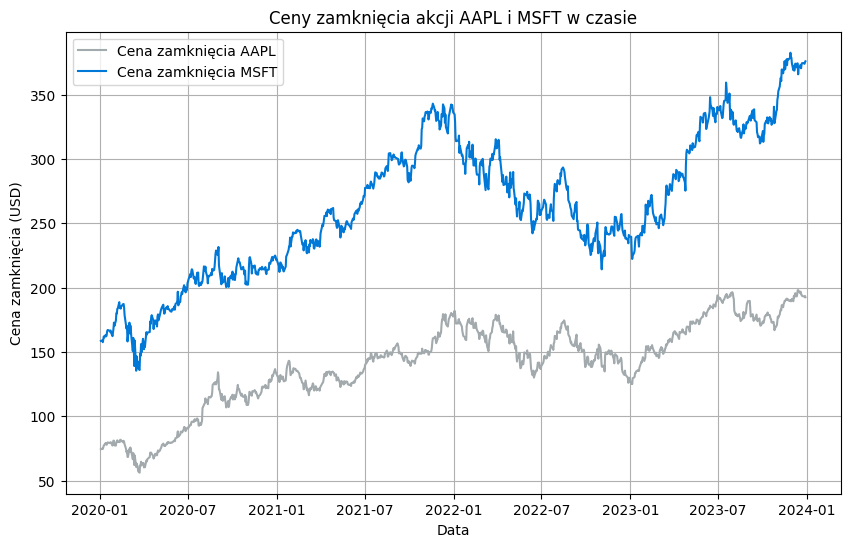

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(data.index, data["Close_AAPL"], color='#A2AAAD', label="Cena zamknięcia AAPL")
plt.plot(data.index, data["Close_MSFT"], color='#0078D7', label="Cena zamknięcia MSFT")
plt.xlabel("Data")
plt.ylabel("Cena zamknięcia (USD)")
plt.title("Ceny zamknięcia akcji AAPL i MSFT w czasie")
plt.legend()
plt.grid()
plt.show()

Czy występuje trend:

In [11]:
trend_test1 = mk.original_test(data['Close_AAPL'])
print(f"Trend: {trend_test1.trend}")
print(f"Nachylenie: {trend_test1.slope}")
print(f"p-value: {trend_test1.p}")

Trend: increasing
Nachylenie: 0.10042755960568679
p-value: 0.0


In [12]:
trend_test2 = mk.original_test(data['Close_MSFT'])
print(f"Trend: {trend_test2.trend}")
print(f"Nachylenie: {trend_test2.slope}")
print(f"p-value: {trend_test2.p}")

Trend: increasing
Nachylenie: 0.16237219414267284
p-value: 0.0


## Zróżnicowanie szeregów czasowych

In [13]:
data["diff_aapl"] = data["Close_AAPL"].diff()
data["diff_msft"] = data["Close_MSFT"].diff()
data = data.dropna()

In [14]:
print(data[["diff_aapl","diff_msft"]].info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1005 entries, 2020-01-03 00:00:00+00:00 to 2023-12-29 00:00:00+00:00
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   diff_aapl  1005 non-null   float64
 1   diff_msft  1005 non-null   float64
dtypes: float64(2)
memory usage: 23.6 KB
None


In [15]:
print(data[["diff_aapl","diff_msft"]].describe())

         diff_aapl    diff_msft
count  1005.000000  1005.000000
mean      0.116858     0.214348
std       2.646546     4.845823
min     -10.519997   -23.410004
25%      -1.300003    -2.449997
50%       0.149994     0.229996
75%       1.660004     3.059998
max      12.000000    19.949982


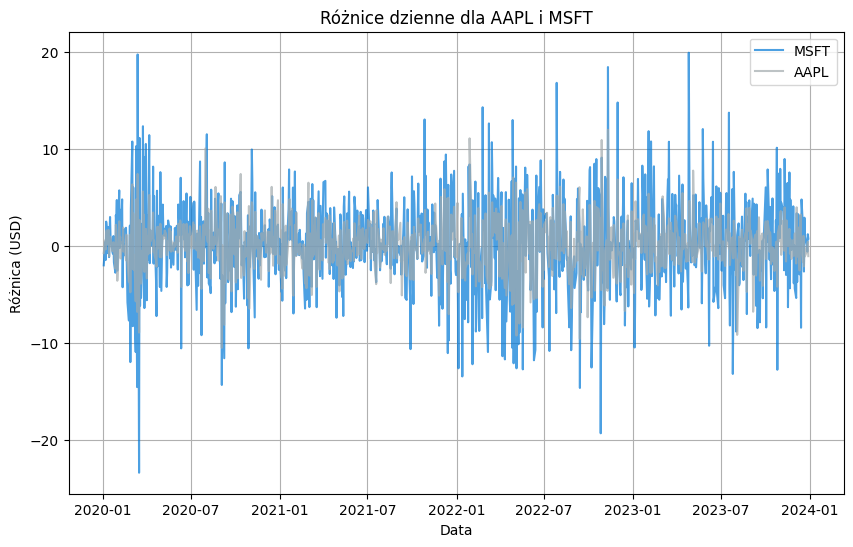

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(data.index, data["diff_msft"], label="MSFT", color="#0078D7", alpha=0.7)
plt.plot(data.index, data["diff_aapl"], label="AAPL", color="#A2AAAD", alpha=0.7)
plt.title("Różnice dzienne dla AAPL i MSFT")
plt.xlabel("Data")
plt.ylabel("Różnica (USD)")
plt.legend()
plt.grid(True)
plt.show()

Wnioski...

Czy pozbyliśmy się trendu?

In [24]:
trend_test1 = mk.original_test(data['diff_aapl'])
print(f"Trend: {trend_test1.trend}")
print(f"Nachylenie: {trend_test1.slope}")
print(f"p-value: {trend_test1.p}")

Trend: no trend
Nachylenie: -8.717606013083212e-05
p-value: 0.7386454235742237


In [25]:
trend_test2 = mk.original_test(data['diff_msft'])
print(f"Trend: {trend_test2.trend}")
print(f"Nachylenie: {trend_test2.slope}")
print(f"p-value: {trend_test2.p}")

Trend: no trend
Nachylenie: -8.545853425003815e-05
p-value: 0.8644741815240118


Czy są stacjonarne?

In [28]:
result1 = adfuller(data["diff_aapl"].dropna())
print(f"p-value: {result1[1]}")

if result1[1] < 0.05:
    print("Odrzucamy hipotezę zerową. Szereg czasowy jest stacjonarny.")
else:
    print("Brak podstaw do odrzucenia hipotezy zerowej. Szereg czasowy jest niestacjonarny.")

p-value: 0.0
Odrzucamy hipotezę zerową. Szereg czasowy jest stacjonarny.


In [29]:
result2 = adfuller(data["diff_aapl"].dropna())
print(f"p-value: {result2[1]}")

if result2[1] < 0.05:
    print("Odrzucamy hipotezę zerową. Szereg czasowy jest stacjonarny.")
else:
    print("Brak podstaw do odrzucenia hipotezy zerowej. Szereg czasowy jest niestacjonarny.")

p-value: 0.0
Odrzucamy hipotezę zerową. Szereg czasowy jest stacjonarny.


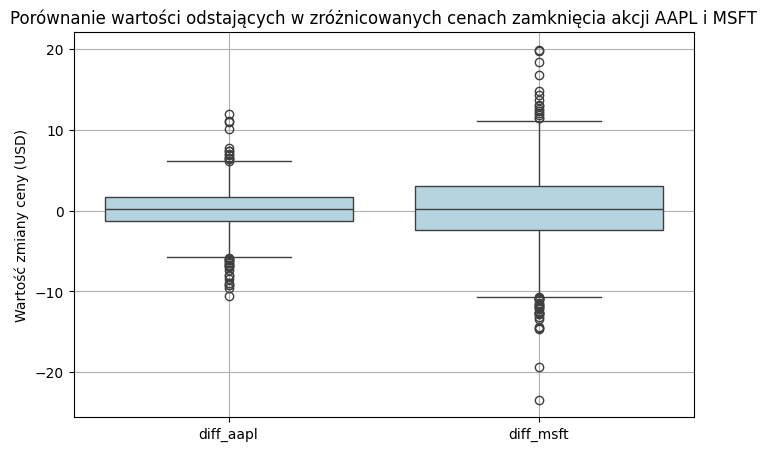

In [20]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=data[["diff_aapl","diff_msft"]], color='lightblue')
plt.title("Porównanie wartości odstających w zróżnicowanych cenach zamknięcia akcji AAPL i MSFT")
plt.xlabel("")
plt.ylabel("Wartość zmiany ceny (USD)")
plt.grid(True)
plt.show()

In [21]:
pearson_corr, pearson_p = pearsonr(data["diff_aapl"], data["diff_msft"])
print(f"Korelacja Pearsona: {pearson_corr}, p-value: {pearson_p}")

Korelacja Pearsona: 0.7216509599122131, p-value: 2.1413031735465261e-162


In [22]:
kendall_corr, kendall_p = kendalltau(data["diff_aapl"], data["diff_msft"])
print(f"Statystyka Tau Kendalla: {kendall_corr}, p-value: {kendall_p}")

Statystyka Tau Kendalla: 0.5582598978439234, p-value: 1.29192123393822e-154


In [23]:
spearman_corr, spearman_p = spearmanr(data["diff_aapl"], data["diff_msft"])
print(f"Statystyka Rho Spearmana: {spearman_corr}, p-value: {spearman_p}")

Statystyka Rho Spearmana: 0.7376369392970201, p-value: 2.8322690443130102e-173


## Dopasowanie rozkładów

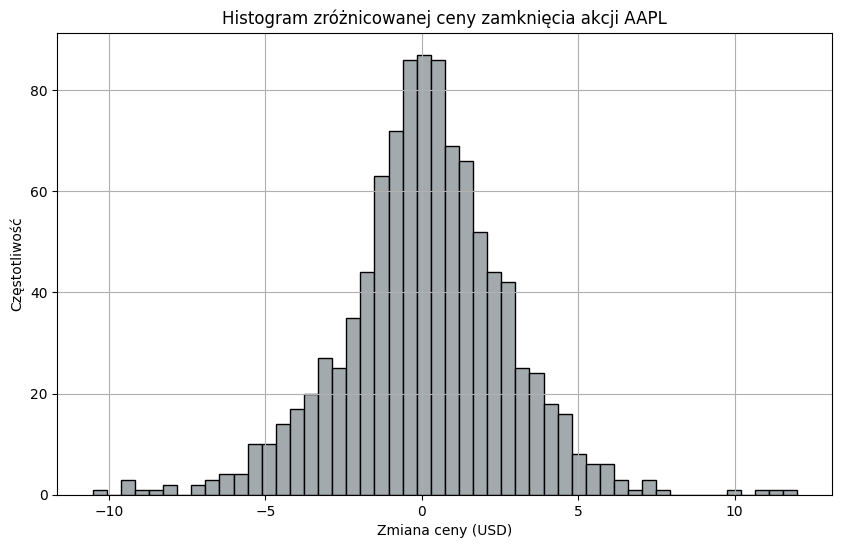

In [30]:
plt.figure(figsize=(10, 6))
data["diff_aapl"].hist(bins=50, edgecolor='k', color='#A2AAAD')
plt.title("Histogram zróżnicowanej ceny zamknięcia akcji AAPL")
plt.xlabel("Zmiana ceny (USD)")
plt.ylabel("Częstotliwość")
plt.grid(True)
plt.show()

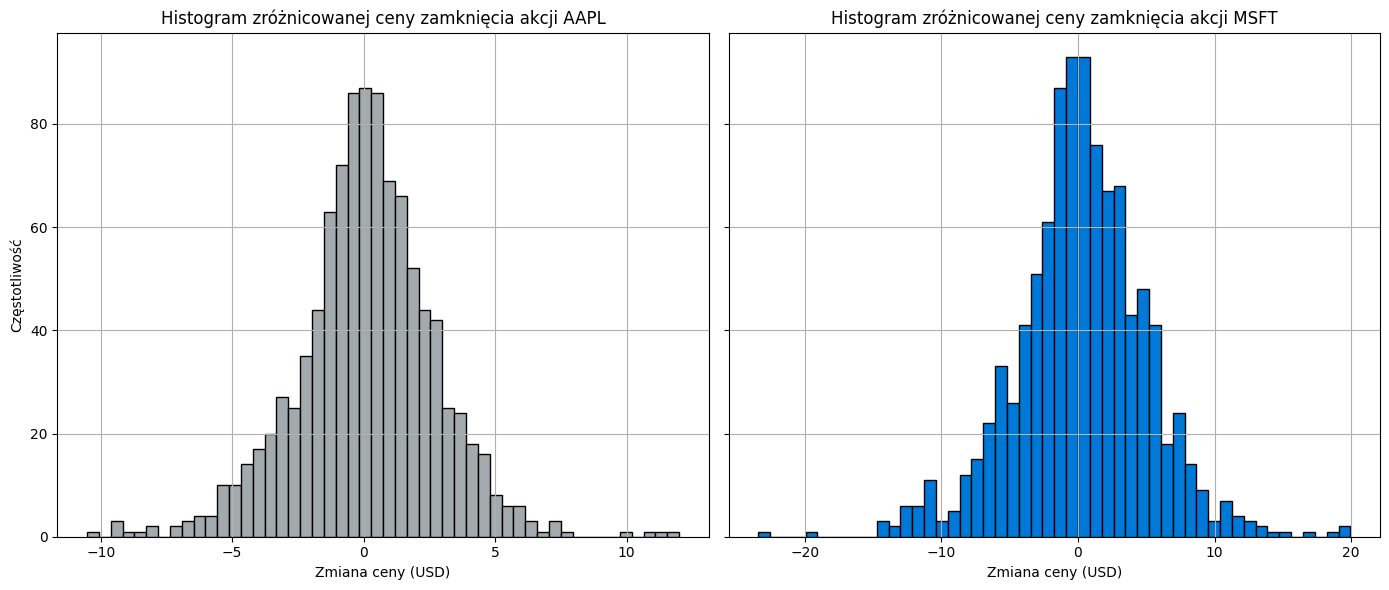

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

axes[0].hist(data["diff_aapl"], bins=50, edgecolor='k', color='#A2AAAD')
axes[0].set_title("Histogram zróżnicowanej ceny zamknięcia akcji AAPL")
axes[0].set_xlabel("Zmiana ceny (USD)")
axes[0].set_ylabel("Częstotliwość")
axes[0].grid(True)

axes[1].hist(data["diff_msft"], bins=50, edgecolor='k', color='#0078D7')
axes[1].set_title("Histogram zróżnicowanej ceny zamknięcia akcji MSFT")
axes[1].set_xlabel("Zmiana ceny (USD)")
axes[1].grid(True)

plt.tight_layout()
plt.show()

Czy są to rozkłady normalne? Test Shapiro-Wilka:

In [32]:
# Test Shapiro-Wilka
stat, p_value = shapiro(data["diff_aapl"])
print(f"Statystyka testowa: {stat}")
print(f"p-value: {p_value}")

if p_value > 0.05:
    print("Brak podstaw do odrzucenia hipotezy. Dane mogą pochodzić z rozkładu normalnego.")
else:
    print("Odrzucamy hipotezę. Dane nie są zgodne z rozkładem normalnym.")

Statystyka testowa: 0.9822238288274578
p-value: 1.0002383593726718e-09
Odrzucamy hipotezę. Dane nie są zgodne z rozkładem normalnym.


In [33]:
# Test Shapiro-Wilka
stat, p_value = shapiro(data["diff_msft"])
print(f"Statystyka testowa: {stat}")
print(f"p-value: {p_value}")

if p_value > 0.05:
    print("Brak podstaw do odrzucenia hipotezy. Dane mogą pochodzić z rozkładu normalnego.")
else:
    print("Odrzucamy hipotezę. Dane nie są zgodne z rozkładem normalnym.")

Statystyka testowa: 0.9834952272420803
p-value: 3.050641445389194e-09
Odrzucamy hipotezę. Dane nie są zgodne z rozkładem normalnym.


Czy są to rozkłady t-Studenta? Test Kołmogorowa-Smirnowa:

In [35]:
# Test Kołmogorowa-Smirnowa
params = t.fit(data["diff_aapl"])

stat, p_value = kstest(data["diff_aapl"], 't', args=params)
print(f"Statystyka testowa: {stat}")
print(f"p-value: {p_value}")

if p_value > 0.05:
    print("Brak podstaw do odrzucenia hipotezy. Dane mogą pochodzić z rozkładu t-Studenta.")
else:
    print("Odrzucamy hipotezę. Dane nie są zgodne z rozkładem t-Studenta.")

Statystyka testowa: 0.016842011857456818
p-value: 0.9333777782839556
Brak podstaw do odrzucenia hipotezy. Dane mogą pochodzić z rozkładu t-Studenta.


In [36]:
# Test Kołmogorowa-Smirnowa
params = t.fit(data["diff_msft"])

stat, p_value = kstest(data["diff_msft"], 't', args=params)
print(f"Statystyka testowa: {stat}")
print(f"p-value: {p_value}")

if p_value > 0.05:
    print("Brak podstaw do odrzucenia hipotezy. Dane mogą pochodzić z rozkładu t-Studenta.")
else:
    print("Odrzucamy hipotezę. Dane nie są zgodne z rozkładem t-Studenta.")

Statystyka testowa: 0.020821417773338513
p-value: 0.7680382189265599
Brak podstaw do odrzucenia hipotezy. Dane mogą pochodzić z rozkładu t-Studenta.


## Dopasowanie kopuł
Dopasujemy pięć kopuł i ocenimy ich dopasowanie:
- eliptyczne - T-studenta, normalna,
- archimedejskie - Gumbela, Claytona, Franka.

Sprawdzimy jak wygląda nasz rozkład łączny:

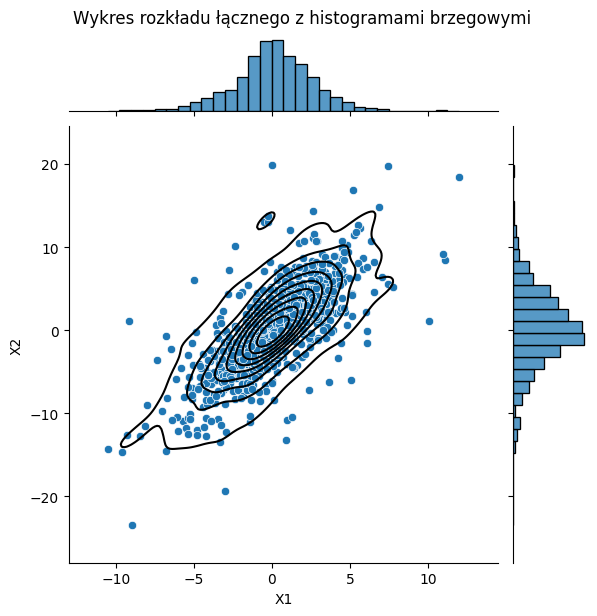

In [38]:
g = sns.jointplot(x="diff_aapl", y="diff_msft", data=data, kind="scatter", marginal_kws=dict(bins=30, fill=True))

g.fig.suptitle("Wykres rozkładu łącznego z histogramami brzegowymi", y=1.02)
sns.kdeplot(data=data, x="diff_aapl", y="diff_msft", color="black")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

Przekształcenie zróżnicowanych szeregów na dystrybuanty brzegowe:

In [41]:
fitted_marginals = {
    0: student_t.fit(data["diff_aapl"]),
    1: student_t.fit(data["diff_msft"])
}

data["u1"] = fitted_marginals[0].cdf(np.array(data["diff_aapl"]))
data["u2"] = fitted_marginals[1].cdf(np.array(data["diff_msft"]))

## Kopuła T-Studenta

In [42]:
student_t_fit = student_t_copula.fit(data[["u1", "u2"]], mdists=fitted_marginals)

In [43]:
results = pd.DataFrame({
    "Copula": ["Student-t"],
    "Log-Likelihood": [student_t_fit.loglikelihood()],
    "AIC": [student_t_fit.aic()],
    "BIC": [student_t_fit.bic()]
})

print(results.loc[0])

Copula              Student-t
Log-Likelihood   -3652.716181
AIC               7321.432361
BIC               7360.734304
Name: 0, dtype: object


## Kopuła Gaussa

In [46]:
gaussian_fit = gaussian_copula.fit(data[["u1", "u2"]], mdists=fitted_marginals)

results = pd.concat(
    [results, pd.DataFrame({
        "Copula": ["Gaussian"],
        "Log-Likelihood": [gaussian_fit.loglikelihood()],
        "AIC": [gaussian_fit.aic()],
        "BIC": [gaussian_fit.bic()],
    })],
    ignore_index=True
)

print(results.loc[1])

Copula               Gaussian
Log-Likelihood   -3657.334139
AIC               7328.668278
BIC               7363.057478
Name: 1, dtype: object


## Kopuła Claytona - zła, niedobra

In [47]:
clayton_fit = clayton_copula.fit(data[["u1", "u2"]], mdists=fitted_marginals, verbose=True)

results = pd.concat(
    [results, pd.DataFrame({
        "Copula": ["Clayton"],
        "Log-Likelihood": [clayton_fit.loglikelihood()],
        "AIC": [clayton_fit.aic()],
        "BIC": [clayton_fit.bic()],
    })],
    ignore_index=True
)

print(results.loc[2])

Copula                Clayton
Log-Likelihood    1324.852209
AIC              -2633.704418
BIC              -2594.402476
Name: 2, dtype: object


C:\Users\magda\repos\Market_risk\venv\lib\site-packages\scipy\optimize\_differentiable_functions.py:551: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)
C:\Users\magda\repos\Market_risk\venv\lib\site-packages\scipy\optimize\_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
C:\Users\magda\repos\Market_risk\venv\lib\site-packages\sklarpy\multivariate\_prefit_dists.py:620: RuntimeWarning: overflow encountered in exp
  return np.exp(loglikelihood)
C:\Users\magda\repos\Market_risk\venv\lib\site-packages\sklarpy\copulas\_prefit_dists.py:1053: R

## Kopuła Gumbela

In [48]:
gumbel_fit = gumbel_copula.fit(data[["u1", "u2"]], mdists=fitted_marginals)

results = pd.concat(
    [results, pd.DataFrame({
        "Copula": ["Gumbel"],
        "Log-Likelihood": [gumbel_fit.loglikelihood()],
        "AIC": [gumbel_fit.aic()],
        "BIC": [gumbel_fit.bic()],
    })],
    ignore_index=True
)

print(results.loc[3])

Copula                 Gumbel
Log-Likelihood   -2621.583016
AIC               5259.166032
BIC               5298.467975
Name: 3, dtype: object


C:\Users\magda\repos\Market_risk\venv\lib\site-packages\sklarpy\multivariate\_prefit_dists.py:620: RuntimeWarning: overflow encountered in exp
  return np.exp(loglikelihood)


## Kopuła Franka

In [49]:
frank_fit = frank_copula.fit(data[["u1", "u2"]], mdists=fitted_marginals)

results = pd.concat(
    [results, pd.DataFrame({
        "Copula": ["Frank"],
        "Log-Likelihood": [frank_fit.loglikelihood()],
        "AIC": [frank_fit.aic()],
        "BIC": [frank_fit.bic()],
    })],
    ignore_index=True
)

print(results.loc[4])

Copula                  Frank
Log-Likelihood   -2598.689244
AIC               5213.378489
BIC               5252.680431
Name: 4, dtype: object


C:\Users\magda\repos\Market_risk\venv\lib\site-packages\scipy\optimize\_differentiable_functions.py:551: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)
C:\Users\magda\repos\Market_risk\venv\lib\site-packages\scipy\optimize\_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
C:\Users\magda\repos\Market_risk\venv\lib\site-packages\sklarpy\multivariate\_prefit_dists.py:620: RuntimeWarning: overflow encountered in exp
  return np.exp(loglikelihood)


In [50]:
print("\nZestawienie wyników dla wszystkich kopuł:")
print(results)


Zestawienie wyników dla wszystkich kopuł:
      Copula  Log-Likelihood          AIC          BIC
0  Student-t    -3652.716181  7321.432361  7360.734304
1   Gaussian    -3657.334139  7328.668278  7363.057478
2    Clayton     1324.852209 -2633.704418 -2594.402476
3     Gumbel    -2621.583016  5259.166032  5298.467975
4      Frank    -2598.689244  5213.378489  5252.680431


In [51]:
results_sorted = results.sort_values(by="BIC", ascending=True).reset_index(drop=True)

best_copula = results_sorted.iloc[0]
print("\nNajlepsza kopuła według BIC:")
print(best_copula)

print("\nTabela z wynikami (posortowana według BIC):")
print(results_sorted)


Najlepsza kopuła według BIC:
Copula                Clayton
Log-Likelihood    1324.852209
AIC              -2633.704418
BIC              -2594.402476
Name: 0, dtype: object

Tabela z wynikami (posortowana według BIC):
      Copula  Log-Likelihood          AIC          BIC
0    Clayton     1324.852209 -2633.704418 -2594.402476
1      Frank    -2598.689244  5213.378489  5252.680431
2     Gumbel    -2621.583016  5259.166032  5298.467975
3  Student-t    -3652.716181  7321.432361  7360.734304
4   Gaussian    -3657.334139  7328.668278  7363.057478


Clayton odpada, zwraca błędne wyniki, coś jest nie tak z implementacją?

Najlepsza kopuła wedlug BIC to kopuła Franka. Sprawdzimy dopasowanie kopuł generując z nich przykładowe próbki i porównując je z rozkładem łącznym oryginalnych danych. Możemy wygenerować próbki za pomocą metody rvs():

In [52]:
student_t_samples = student_t_fit.rvs(len(data))
gaussian_samples = gaussian_fit.rvs(len(data))
clayton_samples = clayton_fit.rvs(len(data))
gumbel_samples = gumbel_fit.rvs(len(data))
frank_samples = frank_fit.rvs(len(data))

Rysujemy wykresy rozkładu dwuwymiarowego uzywając sns.kdeplot(x,y). Punkty na wykresie oznaczają dane oryginalne, natomiast linie zostały wygenerowane na podstawie próbek z dopasowanych kopuł:

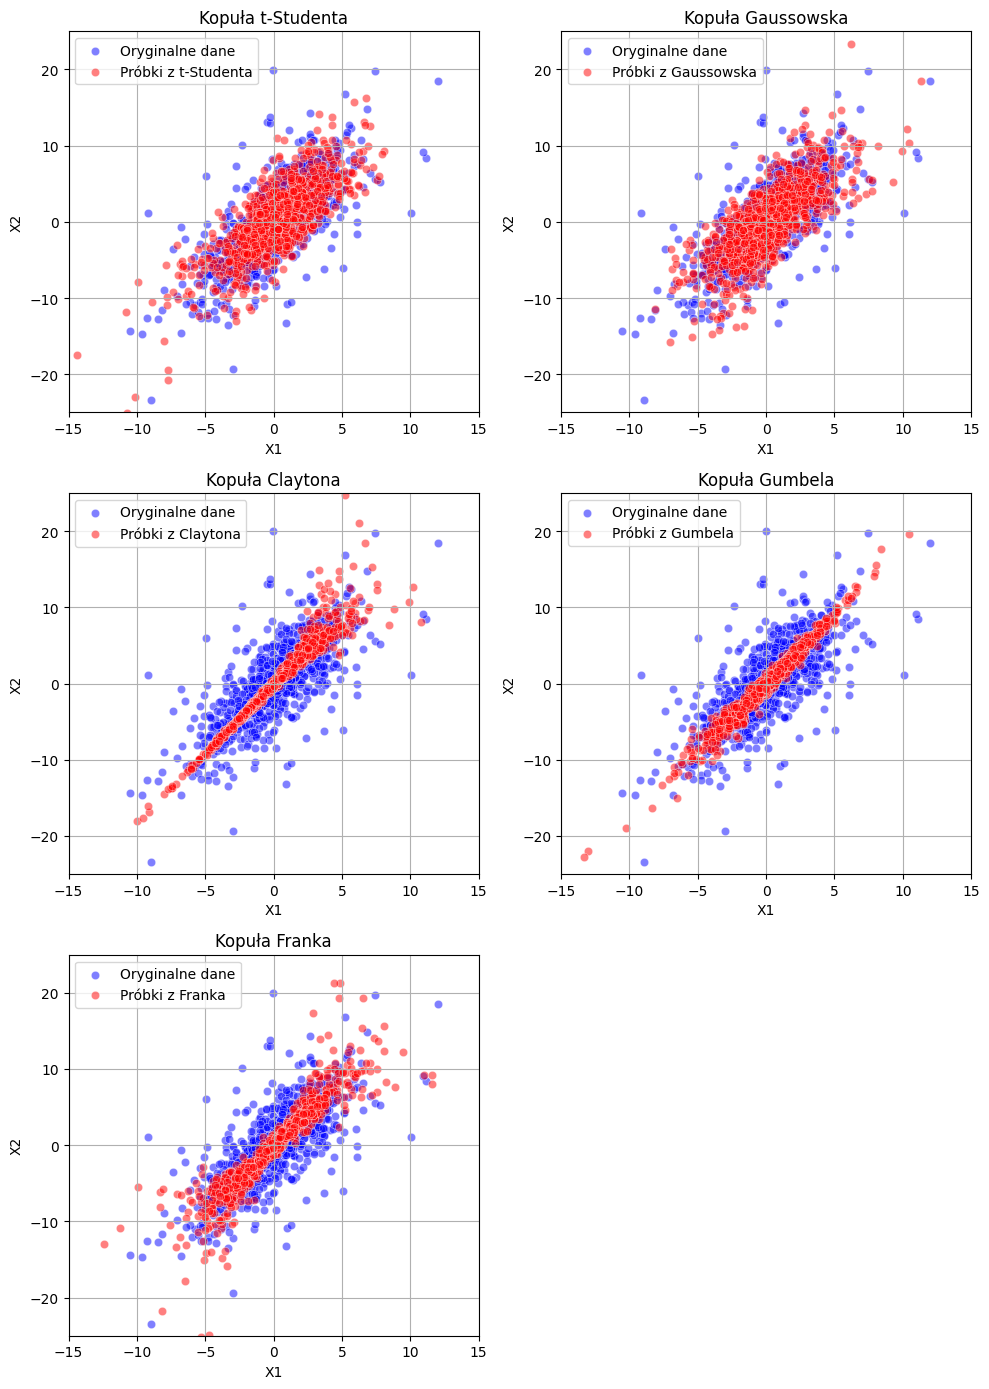

In [61]:
fig, ax = plt.subplots(3, 2, figsize=(10, 14))
axes = ax.flatten()

copula_samples = [
    (student_t_samples, "Kopuła t-Studenta"),
    (gaussian_samples, "Kopuła Gaussowska"),
    (clayton_samples, "Kopuła Claytona"),
    (gumbel_samples, "Kopuła Gumbela"),
    (frank_samples, "Kopuła Franka")
]

for i, (samples, title) in enumerate(copula_samples):
    sns.scatterplot(
        x=data["diff_aapl"], y=data["diff_msft"],
        ax=axes[i], color="blue", alpha=0.5, label="Oryginalne dane"
    )
    # sns.kdeplot(data=data, x="diff_aapl", y="diff_msft", ax=axes[i], color="black")
    sns.scatterplot(
        x=samples[:, 0], y=samples[:, 1],
        ax=axes[i], color="red", alpha=0.5, label=f"Próbki z {title.split()[-1]}"
    )
    # sns.kdeplot(x=samples[:, 0], y=samples[:, 1], ax=axes[i], color="red")
    axes[i].set_title(title)
    axes[i].set_xlabel("X1")
    axes[i].set_ylabel("X2")
    axes[i].legend()
    axes[i].set_xlim(-15, 15)
    axes[i].set_ylim(-25, 25)
    axes[i].grid(True)

axes[-1].axis("off")

plt.tight_layout()
plt.show()

Wnioski...

## Test Mardia
Możemy wykonać test na wielowymiarową normalność:

In [63]:
mardia_test = multivariate_normality(data[["diff_aapl", "diff_msft"]], alpha=0.05)

print("Test Mardia:")
print(mardia_test)

Test Mardia:
HZResults(hz=np.float64(10.909247830035115), pval=np.float64(2.901245832950819e-24), normal=False)


Niska wartość p oznacza, że możemy odrzucić hipotezę zerową, czyli założenie, że dane są wielowymiarowo normalne.

## Krok 4a

## Krok 4b

## Krok 5